In [444]:
import numpy as np
import matplotlib.pyplot as plt
from TDMA import TDMA   

In [445]:

# --- Load data ---
xc = np.loadtxt('xc.dat')   # grid lines in x (faces) length = nim1
yc = np.loadtxt('yc.dat')   # grid lines in y (faces) length = njm1
u = np.loadtxt('u.dat')     # velocities in MATLAB column-major ordering, length = ni*nj
v = np.loadtxt('v.dat')

# --- Grid bookkeeping (match your original logic) ---
nim1 = len(xc)        # number of grid-lines / faces in x
ni = nim1 + 1         # total nodes (including boundaries) in x-direction
njm1 = len(yc)
nj = njm1 + 1

# reshape velocity arrays (MATLAB column-major => order='F')
u2d = np.reshape(u, (ni, nj), order='F')
v2d = np.reshape(v, (ni, nj), order='F')


In [446]:
# plt.plot(yc)

In [447]:
## Paraameters

rho = 1
k = 1
# cp = k*50
gamma = 0.02
Ua = 1
Vd = 0
Ub = 0
Uc = 1

T_right_boundary_value = 0
T_left_boundary_value = 20
T_top_boundary_value = 0
T_bottom_boundary_value = 10

ep = 1e-5 # Some small value i am adding for division so no inf 

In [448]:
def local_Pe(rho, u_e, u_w, v_n, v_s, del_xe, del_xw, del_xn, del_xs, k_over_cp=1/50):
    factor = rho / k_over_cp  # since k/cp = 1/50

    Pe_e = factor * u_e * del_xe
    Pe_w = factor * u_w * del_xw
    Pe_n = factor * v_n * del_xn
    Pe_s = factor * v_s * del_xs

    Pe_x = (Pe_e + Pe_w) / 2
    Pe_y = (Pe_n + Pe_s) / 2

    Pe_local = np.sqrt(Pe_x**2 + Pe_y**2)

    return Pe_local

In [449]:
Nx = 26
Ny = 26
grid_shape = [Nx, Ny] # x, y

N = grid_shape[0] * grid_shape[1]
A = np.zeros((N, N))
B = np.zeros(N)



In [ ]:

# --- Load data ---
xc = np.loadtxt('xc.dat')   # grid lines in x (faces) length = nim1
yc = np.loadtxt('yc.dat')   # grid lines in y (faces) length = njm1
u = np.loadtxt('u.dat')     # velocities in MATLAB column-major ordering, length = ni*nj
v = np.loadtxt('v.dat')


## Paraameters

rho = 1
k = 1
# cp = k*50
gamma = 0.02
Ua = 1
Vd = 0
Ub = 0
Uc = 1

T_right_boundary_value = 0
T_left_boundary_value = 20
T_top_boundary_value = 0
T_bottom_boundary_value = 10

ep = 1e-5 # Some small value i am adding for division so no inf 

# --- Grid bookkeeping (match your original logic) ---
nim1 = len(xc)        # number of grid-lines / faces in x
ni = nim1 + 1         # total nodes (including boundaries) in x-direction
njm1 = len(yc)
nj = njm1 + 1

# reshape velocity arrays (MATLAB column-major => order='F')
u2d = np.reshape(u, (ni, nj), order='F')
v2d = np.reshape(v, (ni, nj), order='F')


Nx = 26
Ny = 26
grid_shape = [Nx, Ny] # x, y

N = grid_shape[0] * grid_shape[1]
A = np.zeros((N, N))
B = np.zeros(N)

Pe_history = []

for y in range(grid_shape[1]):
    for x in range(grid_shape[0]):
        n = y * grid_shape[0] + x

        del_xe, del_xw, del_xn, del_xs = [None]*4
        a_e = a_w = a_n = a_s = 0.0

        if x == 0: 
            del_xw = xc[0]/2
        if x == grid_shape[0]-1:
            del_xe = xc[-1]/2
        if y == 0: 
            del_xs = yc[0]/2
        if y == grid_shape[1]-1:
            del_xn = yc[-1]/2

        # if x != 0 and x != grid_shape[0]-1 and y != 0 and y != grid_shape[1]-1:
        # if del_xw is None: del_xw = xc[x] - xc[x-1]
        # if del_xe is None: del_xe = xc[x+1] - xc[x]
        # if del_xs is None: del_xs = yc[y] - yc[y - 1]
        # if del_xn is None: del_xn = yc[y + 1] - yc[y]

        if del_xw is None and x > 0:
            del_xw = xc[x] - xc[x-1]
        if del_xe is None and x < grid_shape[0]-1:
            del_xe = xc[x+1] - xc[x]
        if del_xs is None and y > 0:
            del_xs = yc[y] - yc[y-1]
        if del_xn is None and y < grid_shape[1]-1:
            del_xn = yc[y+1] - yc[y]
        
        
        Pe = local_Pe(
                rho,
                u_e = u2d[y, x+1],
                u_w = u2d[y, x],
                v_n = v2d[y, x],
                v_s = v2d[y+1, x], 
                del_xe = del_xe,
                del_xw = del_xw,
                del_xn = del_xn,
                del_xs = del_xs
            )
        Pe_history.append(Pe)
    
        # Convection Terms
        Fe = rho * u2d[y, x+1] if x < grid_shape[0]-1 else 0.0
        Fs = rho * v2d[y+1, x] if y < grid_shape[1]-1 else 0.0
        Fw = rho * u2d[y, x]   if x > 0 else 0.0
        Fn = rho * v2d[y, x]   if y > 0 else 0.0 

        # Diffusion Terms
        Dn = gamma / (del_xn + ep)
        Ds = gamma / (del_xs + ep)
        De = gamma / (del_xe + ep)
        Dw = gamma / (del_xw + ep) 
        
        if x == 0 and y == 0:
            Fw = rho * Ua
            
        if y == 0 and x == 13:
            Fs = rho * Vd
        
        if y == grid_shape[1]-1 and x == 0:
            Fw = rho * Ub

        if y == grid_shape[1]-1 and x == grid_shape[0]-1:
            Fw = rho * Uc
        # Pe = 10
        if Pe < 2:
                # CD Scheme

                a_n = -Fn/2 + Dn
                a_s =  Fs/2 + Ds
                a_e = -Fe/2 + De
                a_w =  Fw/2 + Dw

                ap = a_n + a_s + a_e + a_w
                
        else:
            # Upwind Scheme

            a_e = De if Fe>0 else De + abs(Fe)
            a_w = Dw + Fw if Fw>0 else Dw
            a_n = Dn if Fn>0 else Dn + abs(Fn)
            a_s = Ds + Fs if Fs>0 else Ds
            
        a_p = a_e + a_w + a_n + a_s + (Fe - Fw + Fn - Fs)

        

       


In [451]:
a_e

np.float64(0.019999800001999978)

In [452]:
# phi_vec = np.linalg.solve(A, B)
# Ts = phi_vec.reshape(grid_shape[1], grid_shape[0])  # rows=y, cols=x

In [453]:
T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 

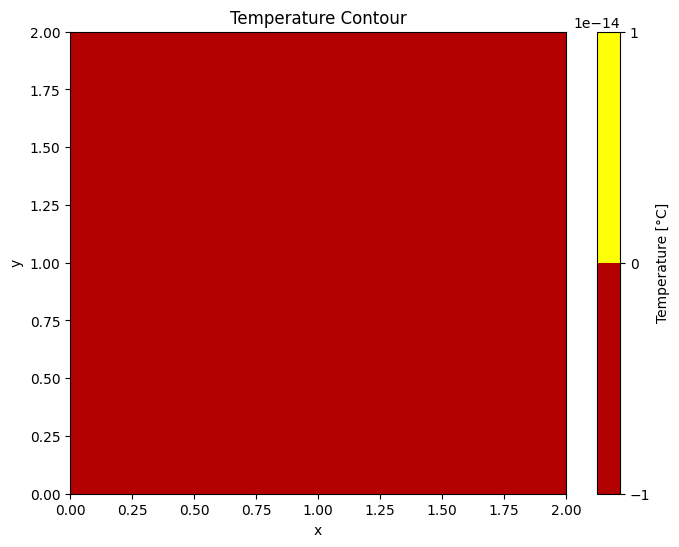

In [454]:
Ts_plot = Ts.T  # now shape (Ny, Nx)
Ts_plot = T
# Create meshgrid for coordinates
X, Y = np.meshgrid(xc, yc)  # xc = x-coordinates, yc = y-coordinates

# Contour plot
plt.figure(figsize=(8,6))
contour = plt.contourf(X, Y, Ts_plot, 20, cmap='hot')  # 20 contour levels
plt.colorbar(contour, label='Temperature [°C]')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Temperature Contour')
plt.show()

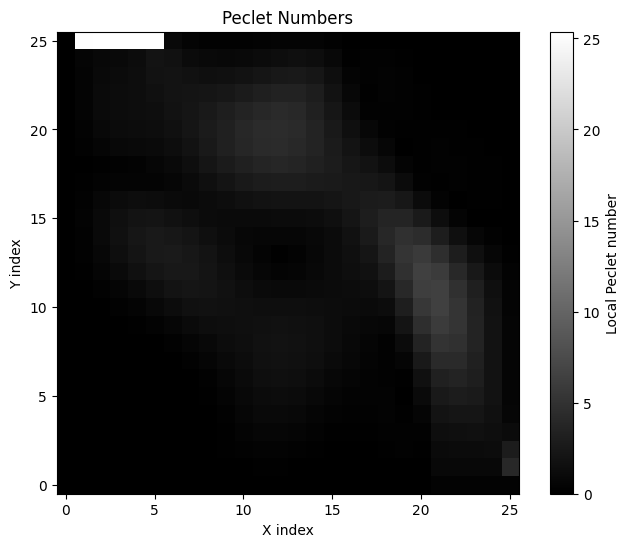

In [455]:
Pe_grid = np.array(Pe_history).reshape(grid_shape[0], grid_shape[1])
plt.figure(figsize=(8,6))
plt.imshow(Pe_grid.T, origin='lower', cmap='gray', interpolation='none')  # transpose for correct orientation
plt.colorbar(label='Local Peclet number')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.title('Peclet Numbers')
plt.show()

Loading grid and velocity data...
✓ Data files loaded successfully
Grid dimensions: 26 x 26 cells
xc range: [0.0000, 2.0000]
yc range: [0.0000, 2.0000]
Velocity arrays: u(27, 27), v(27, 27)
u range: [-0.3258, 1.1215]
v range: [-0.6897, 0.2237]
dx range: [0.000000, 0.165617]
dy range: [0.000000, 0.165617]
Domain: L=2.0000, H=2.0000, hA=0.1360
Under-relaxation: α = 0.3


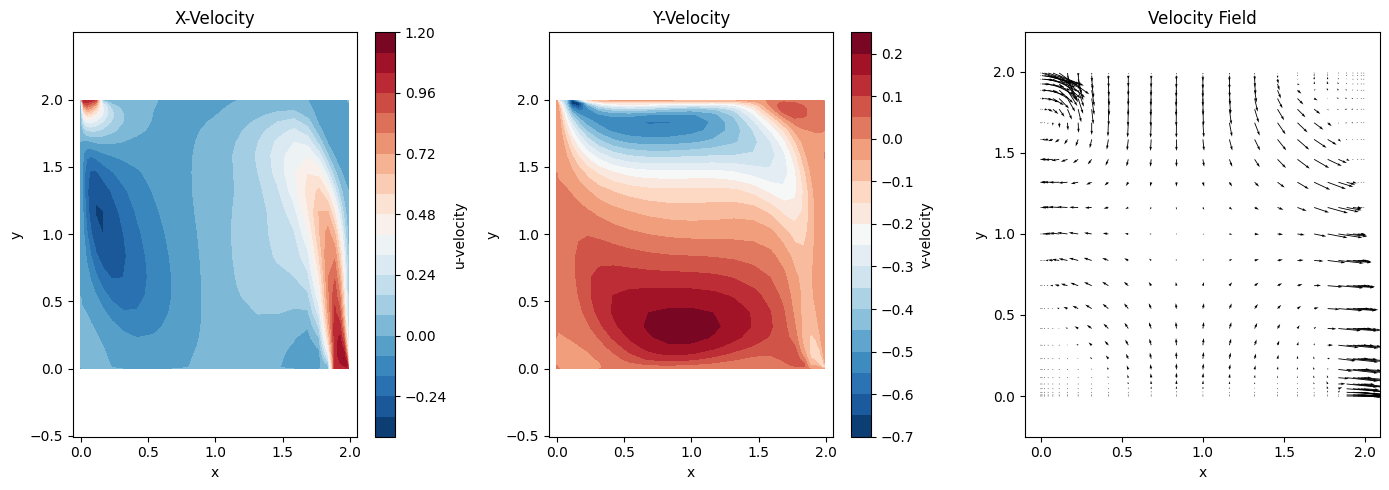

Initial T range: [20.00, 49.90] °C

TDMA SOLVER - NON-UNIFORM MESH

Starting iterations...
Iter    0: ε = nan, T=[14.00, 49.90]


/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_20703/380256021.py:167: RuntimeWarning: invalid value encountered in scalar divide
  Dw = Gamma * dy_local / dx_w
/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_20703/380256021.py:169: RuntimeWarning: invalid value encountered in scalar divide
  Ds = Gamma * dx_local / dy_s
/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_20703/380256021.py:169: RuntimeWarning: divide by zero encountered in scalar divide
  Ds = Gamma * dx_local / dy_s
/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_20703/380256021.py:167: RuntimeWarning: divide by zero encountered in scalar divide
  Dw = Gamma * dy_local / dx_w
/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_20703/380256021.py:230: RuntimeWarning: invalid value encountered in scalar divide
  d_star[0] = d[0] / b[0]
/var/folders/3p/xlr6tgyx4t980qpxnnrs12kc0000gn/T/ipykernel_20703/380256021.py:237: RuntimeWarning: invalid value encountered in scalar div

Iter  100: ε = nan, T=[10.00, 49.90]
Iter  200: ε = nan, T=[10.00, 49.88]
Iter  300: ε = nan, T=[10.00, 49.87]
Iter  400: ε = nan, T=[10.00, 49.87]
Iter  500: ε = nan, T=[10.00, 49.86]
Iter  600: ε = nan, T=[10.00, 49.86]
Iter  700: ε = nan, T=[10.00, 49.85]
Iter  800: ε = nan, T=[10.00, 49.85]
Iter  900: ε = nan, T=[10.00, 49.84]
Iter 1000: ε = nan, T=[10.00, 49.84]
Iter 1100: ε = nan, T=[10.00, 49.84]
Iter 1200: ε = nan, T=[10.00, 49.84]
Iter 1300: ε = nan, T=[10.00, 49.83]
Iter 1400: ε = nan, T=[10.00, 49.83]
Iter 1500: ε = nan, T=[10.00, 49.83]
Iter 1600: ε = nan, T=[10.00, 49.83]
Iter 1700: ε = nan, T=[10.00, 49.83]
Iter 1800: ε = nan, T=[10.00, 49.82]
Iter 1900: ε = nan, T=[10.00, 49.82]
Iter 2000: ε = nan, T=[10.00, 49.82]
Iter 2100: ε = nan, T=[10.00, 49.82]
Iter 2200: ε = nan, T=[10.00, 49.82]
Iter 2300: ε = nan, T=[10.00, 49.81]
Iter 2400: ε = nan, T=[10.00, 49.81]
Iter 2500: ε = nan, T=[10.00, 49.81]
Iter 2600: ε = nan, T=[10.00, 49.81]
Iter 2700: ε = nan, T=[10.00, 49.81]
I

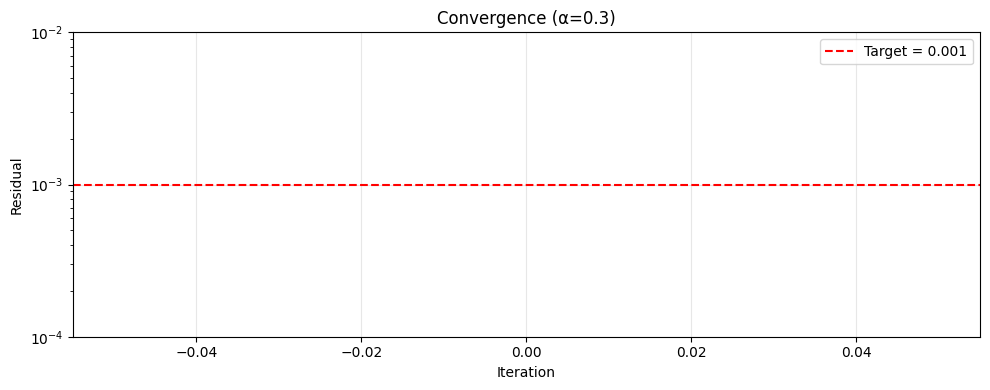

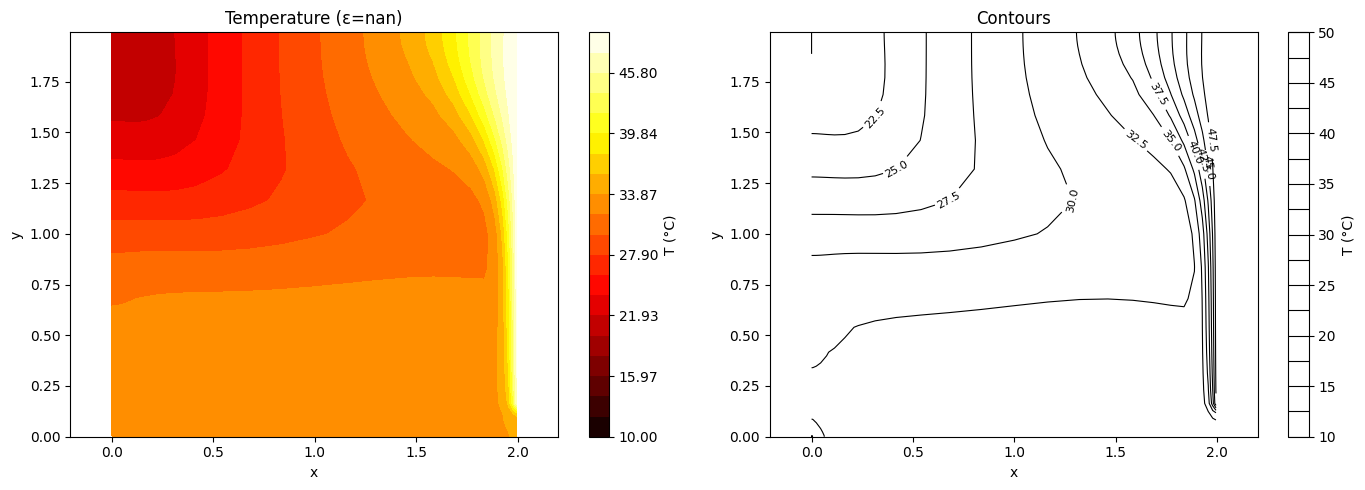


HEAT FLUX CONSERVATION
Left:      -0.114821 W
Right:   -323.539459 W
Top:      -63.522824 W
Bottom:     0.071625 W
------------------------------------------------------------
Total:   -387.105478 W
Error:  119.6471 %

SUMMARY
Converged: NO
Residual: nan
Iterations: 5000
Temperature: [10.00, 49.78] °C


In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Physical parameters from assignment
rho = 1.0
k = 1.0
cp = 50.0
Gamma = k / cp  # Gamma = k/cp = 1/50 = 0.02

# Boundary conditions from Figure 1
UA = 1.0  # Left-top inlet velocity
UB = 0.0  # Left-bottom velocity
UC = 1.0  # Right outlet velocity
VD = 0.0  # Top inlet velocity
TA = 20.0  # Temperature at left wall (inlet)
# At x=L (other than outlet): T = 50°C

# From assignment: hA/H = hC/H = 0.068
h_ratio = 0.068

# Convergence criterion
epsilon_target = 0.001
alpha = 0.3  # Lower under-relaxation for stability (increased from 0.7)

# Load grid and velocity field
print("Loading grid and velocity data...")
try:
    xc = np.loadtxt('xc.dat')
    yc = np.loadtxt('yc.dat')
    u_flat = np.loadtxt('u.dat')
    v_flat = np.loadtxt('v.dat')
    print("✓ Data files loaded successfully")
except:
    print("ERROR: Could not load data files. Make sure xc.dat, yc.dat, u.dat, v.dat are in the current directory.")
    exit()

# Grid dimensions
nim1 = len(xc)
njm1 = len(yc)
ni = nim1 + 1
nj = njm1 + 1

print(f"Grid dimensions: {nim1} x {njm1} cells")
print(f"xc range: [{xc[0]:.4f}, {xc[-1]:.4f}]")
print(f"yc range: [{yc[0]:.4f}, {yc[-1]:.4f}]")

# Reshape velocity arrays
u = u_flat.reshape((ni, nj), order='F').T
v = v_flat.reshape((ni, nj), order='F').T

print(f"Velocity arrays: u{u.shape}, v{v.shape}")
print(f"u range: [{np.min(u):.4f}, {np.max(u):.4f}]")
print(f"v range: [{np.min(v):.4f}, {np.max(v):.4f}]")

# Calculate cell widths (NON-UNIFORM MESH)
dx = np.zeros(nim1)
dx[0] = xc[0]
for i in range(1, nim1):
    dx[i] = xc[i] - xc[i-1]

dy = np.zeros(njm1)
dy[0] = yc[0]
for j in range(1, njm1):
    dy[j] = yc[j] - yc[j-1]

print(f"dx range: [{np.min(dx):.6f}, {np.max(dx):.6f}]")
print(f"dy range: [{np.min(dy):.6f}, {np.max(dy):.6f}]")

# Domain dimensions
L = xc[-1]
H = yc[-1]
hA = h_ratio * H
print(f"Domain: L={L:.4f}, H={H:.4f}, hA={hA:.4f}")
print(f"Under-relaxation: α = {alpha}")

# Cell centers
x_cell = np.zeros(nim1)
x_cell[0] = xc[0] / 2
for i in range(1, nim1):
    x_cell[i] = (xc[i-1] + xc[i]) / 2

y_cell = np.zeros(njm1)
y_cell[0] = yc[0] / 2
for j in range(1, njm1):
    y_cell[j] = (yc[j-1] + yc[j]) / 2

X, Y = np.meshgrid(x_cell, y_cell)

# Plot velocity field
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.contourf(X, Y, u[:-1, :-1], 20, cmap='RdBu_r')
plt.colorbar(label='u-velocity')
plt.title('X-Velocity')
plt.xlabel('x'); plt.ylabel('y')
plt.axis('equal')

plt.subplot(1, 3, 2)
plt.contourf(X, Y, v[:-1, :-1], 20, cmap='RdBu_r')
plt.colorbar(label='v-velocity')
plt.title('Y-Velocity')
plt.xlabel('x'); plt.ylabel('y')
plt.axis('equal')

plt.subplot(1, 3, 3)
skip = max(1, nim1 // 20)
plt.quiver(X[::skip, ::skip], Y[::skip, ::skip], 
           u[:-1:skip, :-1:skip], v[:-1:skip, :-1:skip])
plt.title('Velocity Field')
plt.xlabel('x'); plt.ylabel('y')
plt.axis('equal')

plt.tight_layout()
plt.savefig('velocity_field.png', dpi=150, bbox_inches='tight')
plt.show()

# Initialize temperature field with boundary-aware initial guess
T = np.ones((njm1, nim1)) * 35.0
for j in range(njm1):
    for i in range(nim1):
        # Linear interpolation from inlet to outlet
        T[j, i] = TA + (50.0 - TA) * x_cell[i] / L

print(f"Initial T range: [{np.min(T):.2f}, {np.max(T):.2f}] °C")

def hybrid_scheme(Pe):
    """Hybrid differencing scheme"""
    Pe_abs = abs(Pe)
    if Pe_abs <= 2:
        return max(0, 1 - 0.5 * Pe_abs)  # Ensure non-negative
    else:
        return 0.0

def is_inlet_left(j):
    """Check if cell is in inlet region"""
    return y_cell[j] >= (H - hA)

def is_outlet_right(j):
    """Check if cell is in outlet region"""
    return y_cell[j] <= (h_ratio * H)

def calculate_coefficients(i, j, u, v, T, dx, dy, Gamma, rho):
    """Calculate FVM coefficients with stability checks"""
    dx_local = dx[i]
    dy_local = dy[j]
    
    # Face velocities
    u_e = u[j, i+1]
    u_w = u[j, i]
    v_n = v[j+1, i]
    v_s = v[j, i]
    
    # Convective fluxes
    Fe = rho * u_e * dy_local
    Fw = rho * u_w * dy_local
    Fn = rho * v_n * dx_local
    Fs = rho * v_s * dx_local
    
    # Distances to neighbors
    dx_e = (dx[i] + dx[i+1]) / 2 if i < nim1-1 else dx[i] / 2
    dx_w = (dx[i-1] + dx[i]) / 2 if i > 0 else dx[i] / 2
    dy_n = (dy[j] + dy[j+1]) / 2 if j < njm1-1 else dy[j] / 2
    dy_s = (dy[j-1] + dy[j]) / 2 if j > 0 else dy[j] / 2
    
    # Diffusive conductances
    De = Gamma * dy_local / dx_e
    Dw = Gamma * dy_local / dx_w
    Dn = Gamma * dx_local / dy_n
    Ds = Gamma * dx_local / dy_s
    
    # Peclet numbers
    Pe_e = Fe / (De + 1e-20)
    Pe_w = Fw / (Dw + 1e-20)
    Pe_n = Fn / (Dn + 1e-20)
    Pe_s = Fs / (Ds + 1e-20)
    
    # Hybrid scheme with upwind bias for high Pe
    a_E = De * hybrid_scheme(Pe_e) + max(-Fe, 0)
    a_W = Dw * hybrid_scheme(Pe_w) + max(Fw, 0)
    a_N = Dn * hybrid_scheme(Pe_n) + max(-Fn, 0)
    a_S = Ds * hybrid_scheme(Pe_s) + max(Fs, 0)
    
    Su = 0.0
    Sp = 0.0
    
    # Boundary conditions
    if i == 0:
        if is_inlet_left(j):
            Sp -= a_W
            Su += a_W * TA
            a_W = 0
        else:
            a_W = 0
    
    if i == nim1 - 1:
        if is_outlet_right(j):
            a_E = 0
        else:
            Sp -= a_E
            Su += a_E * 50.0
            a_E = 0
    
    if j == njm1 - 1:
        a_N = 0
    
    if j == 0:
        a_S = 0
    
    # Ensure positive diagonal dominance
    a_P = a_E + a_W + a_N + a_S - Sp
    if a_P < 1e-10:
        a_P = 1e-10
    
    return a_E, a_W, a_N, a_S, Su, Sp, a_P

def tdma(a, b, c, d):
    """TDMA solver with stability checks"""
    n = len(d)
    c_star = np.zeros(n-1)
    d_star = np.zeros(n)
    x = np.zeros(n)
    
    # Check for valid input
    if np.any(np.abs(b) < 1e-20):
        print("Warning: Near-zero diagonal in TDMA")
        return x
    
    # Forward elimination
    c_star[0] = c[0] / b[0]
    d_star[0] = d[0] / b[0]
    
    for i in range(1, n-1):
        denom = b[i] - a[i] * c_star[i-1]
        if abs(denom) < 1e-20:
            denom = 1e-20
        c_star[i] = c[i] / denom
        d_star[i] = (d[i] - a[i] * d_star[i-1]) / denom
    
    denom = b[n-1] - a[n-1] * c_star[n-2]
    if abs(denom) < 1e-20:
        denom = 1e-20
    d_star[n-1] = (d[n-1] - a[n-1] * d_star[n-2]) / denom
    
    # Back substitution
    x[n-1] = d_star[n-1]
    for i in range(n-2, -1, -1):
        x[i] = d_star[i] - c_star[i] * x[i+1]
    
    return x

def line_by_line_tdma(T, u, v, dx, dy, Gamma, rho, alpha):
    """Line-by-line TDMA with stability checks"""
    T_new = T.copy()
    
    # X-direction sweep
    for j in range(njm1):
        a_lower = np.zeros(nim1)
        a_diag = np.zeros(nim1)
        a_upper = np.zeros(nim1)
        rhs = np.zeros(nim1)
        
        for i in range(nim1):
            a_E, a_W, a_N, a_S, Su, Sp, a_P = calculate_coefficients(
                i, j, u, v, T_new, dx, dy, Gamma, rho)
            
            T_N = T_new[j+1, i] if j < njm1-1 else T_new[j, i]
            T_S = T_new[j-1, i] if j > 0 else T_new[j, i]
            
            a_P_relaxed = a_P / alpha
            
            a_lower[i] = -a_W
            a_upper[i] = -a_E
            a_diag[i] = a_P_relaxed
            rhs[i] = a_N * T_N + a_S * T_S + Su + (1 - alpha) / alpha * a_P * T[j, i]
        
        T_line = tdma(a_lower, a_diag, a_upper, rhs)
        
        # Check for NaN and clip extreme values
        if np.any(np.isnan(T_line)) or np.any(np.isinf(T_line)):
            print(f"Warning: NaN/Inf detected in x-sweep at j={j}")
            continue
        T_line = np.clip(T_line, TA - 10, 60.0)
        T_new[j, :] = T_line
    
    # Y-direction sweep
    for i in range(nim1):
        a_lower = np.zeros(njm1)
        a_diag = np.zeros(njm1)
        a_upper = np.zeros(njm1)
        rhs = np.zeros(njm1)
        
        for j in range(njm1):
            a_E, a_W, a_N, a_S, Su, Sp, a_P = calculate_coefficients(
                i, j, u, v, T_new, dx, dy, Gamma, rho)
            
            T_E = T_new[j, i+1] if i < nim1-1 else T_new[j, i]
            T_W = T_new[j, i-1] if i > 0 else T_new[j, i]
            
            a_P_relaxed = a_P / alpha
            
            a_lower[j] = -a_S
            a_upper[j] = -a_N
            a_diag[j] = a_P_relaxed
            rhs[j] = a_E * T_E + a_W * T_W + Su + (1 - alpha) / alpha * a_P * T[j, i]
        
        T_line = tdma(a_lower, a_diag, a_upper, rhs)
        
        if np.any(np.isnan(T_line)) or np.any(np.isinf(T_line)):
            print(f"Warning: NaN/Inf detected in y-sweep at i={i}")
            continue
        T_line = np.clip(T_line, TA - 10, 60.0)
        T_new[:, i] = T_line
    
    return T_new

def calculate_residual(T, u, v, dx, dy, Gamma, rho):
    """Calculate residual with safety checks"""
    total_residual = 0.0
    
    for j in range(njm1):
        for i in range(nim1):
            a_E, a_W, a_N, a_S, Su, Sp, a_P = calculate_coefficients(
                i, j, u, v, T, dx, dy, Gamma, rho)
            
            T_E = T[j, i+1] if i < nim1-1 else T[j, i]
            T_W = T[j, i-1] if i > 0 else T[j, i]
            T_N = T[j+1, i] if j < njm1-1 else T[j, i]
            T_S = T[j-1, i] if j > 0 else T[j, i]
            
            R_cell = abs(a_E * T_E + a_W * T_W + a_N * T_N + a_S * T_S + Su - a_P * T[j, i])
            total_residual += R_cell
    
    inlet_mass_flux = 0
    for j in range(njm1):
        if is_inlet_left(j):
            inlet_mass_flux += rho * abs(u[j, 0]) * dy[j]
    
    Delta_T = abs(50.0 - TA)
    f = inlet_mass_flux * Delta_T
    epsilon = total_residual / (f + 1e-10)
    
    return epsilon

def solve_with_tdma(T, u, v, dx, dy, Gamma, rho, alpha, max_iter=5000):
    """Main solver"""
    residual_history = []
    
    print("\nStarting iterations...")
    for iteration in range(max_iter):
        T_old = T.copy()
        
        T = line_by_line_tdma(T, u, v, dx, dy, Gamma, rho, alpha)
        
        # Check for NaN
        if np.any(np.isnan(T)) or np.any(np.isinf(T)):
            print(f"\n ERROR: Solution diverged at iteration {iteration}")
            print("Try reducing alpha (current: {alpha})")
            return T_old, np.nan, iteration, residual_history
        
        if iteration % 10 == 0 or iteration < 5:
            residual = calculate_residual(T, u, v, dx, dy, Gamma, rho)
            residual_history.append((iteration, residual))
            
            if iteration % 100 == 0:
                print(f"Iter {iteration:4d}: ε = {residual:.8f}, T=[{np.min(T):.2f}, {np.max(T):.2f}]")
            
            if residual < epsilon_target and iteration > 20:
                print(f"\n✓ Converged at iteration {iteration}!")
                return T, residual, iteration, residual_history
    
    print(f"\nWarning: Max iterations reached")
    residual = calculate_residual(T, u, v, dx, dy, Gamma, rho)
    return T, residual, max_iter, residual_history

# Solve
print("\n" + "="*60)
print("TDMA SOLVER - NON-UNIFORM MESH")
print("="*60)
T_solution, final_residual, n_iter, res_history = solve_with_tdma(
    T, u, v, dx, dy, Gamma, rho, alpha)

# Plot convergence
if res_history:
    plt.figure(figsize=(10, 4))
    iters, residuals = zip(*res_history)
    plt.semilogy(iters, residuals, 'b-o', markersize=3)
    plt.axhline(y=epsilon_target, color='r', linestyle='--', label=f'Target = {epsilon_target}')
    plt.xlabel('Iteration')
    plt.ylabel('Residual')
    plt.title(f'Convergence (α={alpha})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig('convergence.png', dpi=150)
    plt.show()

# Plot temperature
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
levels = np.linspace(np.min(T_solution), np.max(T_solution), 21)
contour = plt.contourf(X, Y, T_solution, levels=levels, cmap='hot')
plt.colorbar(contour, label='T (°C)')
plt.title(f'Temperature (ε={final_residual:.6f})')
plt.xlabel('x'); plt.ylabel('y')
plt.axis('equal')

plt.subplot(1, 2, 2)
contour2 = plt.contour(X, Y, T_solution, levels=15, colors='black', linewidths=0.8)
plt.clabel(contour2, inline=True, fontsize=8)
plt.colorbar(contour2, label='T (°C)')
plt.title('Contours')
plt.xlabel('x'); plt.ylabel('y')
plt.axis('equal')

plt.tight_layout()
plt.savefig('temperature.png', dpi=150)
plt.show()

# Heat flux check
print("\n" + "="*60)
print("HEAT FLUX CONSERVATION")
print("="*60)

flux_left = flux_right = flux_top = flux_bottom = 0

for j in range(njm1):
    u_face = u[j, 0]
    T_face = TA if (is_inlet_left(j) and u_face > 0) else T_solution[j, 0]
    flux_left += rho * cp * u_face * T_face * dy[j]
    if nim1 > 1:
        dTdx = (T_solution[j, 1] - T_solution[j, 0]) / ((dx[0] + dx[1]) / 2)
        flux_left -= k * dTdx * dy[j]

for j in range(njm1):
    flux_right += rho * cp * u[j, nim1] * T_solution[j, nim1-1] * dy[j]
    if nim1 > 1:
        dTdx = (T_solution[j, nim1-1] - T_solution[j, nim1-2]) / ((dx[nim1-2] + dx[nim1-1]) / 2)
        flux_right -= k * dTdx * dy[j]

for i in range(nim1):
    flux_top += rho * cp * v[njm1, i] * T_solution[njm1-1, i] * dx[i]
    if njm1 > 1:
        dTdy = (T_solution[njm1-1, i] - T_solution[njm1-2, i]) / ((dy[njm1-2] + dy[njm1-1]) / 2)
        flux_top -= k * dTdy * dx[i]

for i in range(nim1):
    flux_bottom += rho * cp * v[0, i] * T_solution[0, i] * dx[i]
    if njm1 > 1:
        dTdy = (T_solution[1, i] - T_solution[0, i]) / ((dy[0] + dy[1]) / 2)
        flux_bottom -= k * dTdy * dx[i]

total_flux = flux_left + flux_right + flux_top + flux_bottom

print(f"Left:   {flux_left:12.6f} W")
print(f"Right:  {flux_right:12.6f} W")
print(f"Top:    {flux_top:12.6f} W")
print(f"Bottom: {flux_bottom:12.6f} W")
print(f"{'-'*60}")
print(f"Total:  {total_flux:12.6f} W")
print(f"Error:  {abs(total_flux)/max(abs(flux_left), abs(flux_right), 1e-10)*100:.4f} %")

print(f"\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Converged: {'YES' if final_residual < epsilon_target else 'NO'}")
print(f"Residual: {final_residual:.6e}")
print(f"Iterations: {n_iter}")
print(f"Temperature: [{np.min(T_solution):.2f}, {np.max(T_solution):.2f}] °C")
print("="*60)


2D CONVECTION-DIFFUSION SOLVER - TDMA LINE-BY-LINE METHOD

Loading data files...
Grid size: 27 x 27
Domain: L = 2.000 m, H = 2.000 m
Grid spacing: dx = 0.0769 m, dy = 0.0769 m
Inlet height h_A = 0.1360 m
Outlet height h_C = 0.1360 m

⚠ OVERRIDING velocity field with boundary condition values
  U_A = 1.0, U_B = 0.0, U_C = 1.0, V_D = 0.0

Starting TDMA iterations (tolerance = 0.001)...
Under-relaxation factor: α = 0.5

Iteration    0: Max change = 1.894190e+01

✓ Converged at iteration 150
  Max change = 2.145021e-05

GLOBAL ENERGY BALANCE CHECK
Inlet flux:     0.000000e+00 W
Outlet flux:    5.384615e+00 W
Wall flux:      8.737541e+00 W
Net imbalance:  -1.412216e+01 W
Error:          0.000%

✓ Energy balance satisfied!

GENERATING PLOTS

✓ Saved: solution_tdma.png


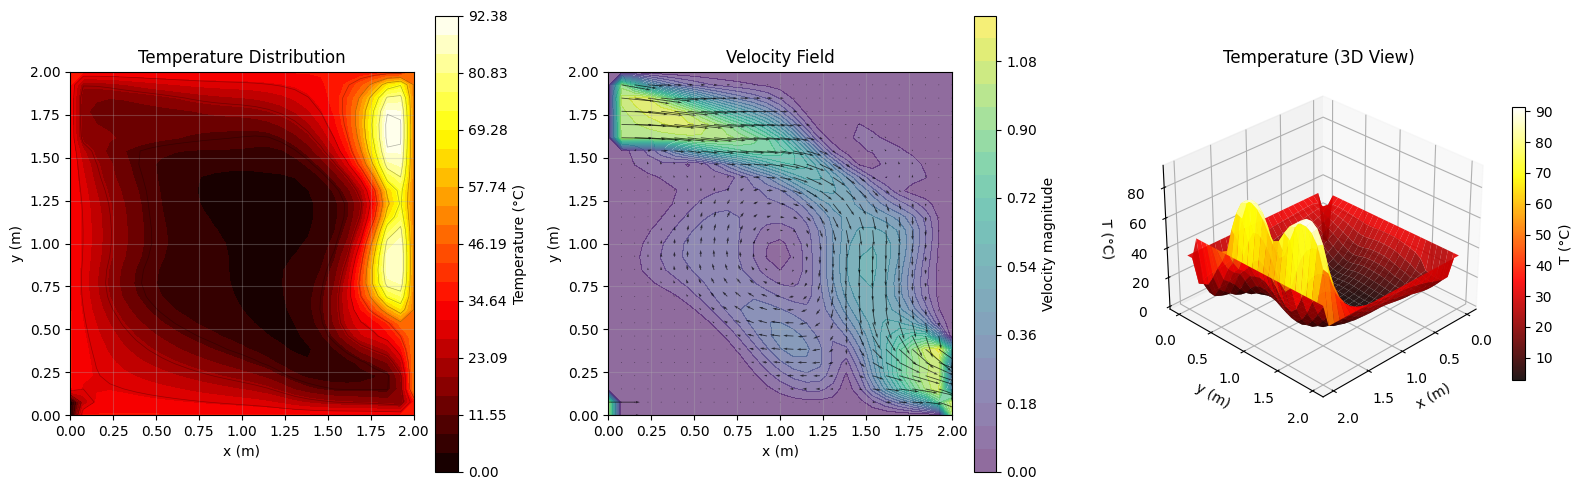


SOLUTION SUMMARY
Temperature range: [0.00, 92.38] °C
Center temperature: T(1.000, 1.000) = 3.47 °C
Energy balance error: 0.000%
Converged in 150 iterations

Done!


In [ ]:
"""
2D Convection-Diffusion Solver with TDMA (Line-by-Line Method)
Simplified and optimized version using TriDiagonal Matrix Algorithm

AM5630 Assignment-3
Boundary Conditions:
- U_A = 1, U_B = 0, U_C = 1, V_D = 0
- T_A = 20°C
- At x = L (except outlet): T = 50°C
- h_A/H = h_C/H = 0.068
"""

import numpy as np
import matplotlib.pyplot as plt

# ============================================================================
# TDMA SOLVER
# ============================================================================
def tdma_solve(a, b, c, d):
    """
    Solve tridiagonal system Ax = d
    a: lower diagonal, b: main diagonal, c: upper diagonal, d: RHS
    """
    n = len(d)
    c_star = np.zeros(n)
    d_star = np.zeros(n)
    
    # Forward sweep
    c_star[0] = c[0] / b[0]
    d_star[0] = d[0] / b[0]
    
    for i in range(1, n):
        denom = b[i] - a[i] * c_star[i-1]
        if i < n-1:
            c_star[i] = c[i] / denom
        d_star[i] = (d[i] - a[i] * d_star[i-1]) / denom
    
    # Back substitution
    x = np.zeros(n)
    x[-1] = d_star[-1]
    for i in range(n-2, -1, -1):
        x[i] = d_star[i] - c_star[i] * x[i+1]
    
    return x

# ============================================================================
# HYBRID SCHEME
# ============================================================================
def hybrid_coeff(D, F):
    """Hybrid differencing: max(D - |F|/2, 0, -F)"""
    return max(D - abs(F)/2, 0, -F)

# ============================================================================
# PARAMETERS
# ============================================================================
rho = 1.0
Gamma = 1.0/50.0

# Boundary conditions
U_A, U_B, U_C, V_D = 1.0, 0.0, 1.0, 0.0
T_A, T_wall = 20.0, 50.0

# Solver settings
max_iter = 2000
tolerance = 1e-3
alpha = 0.5  # Under-relaxation factor

# Set to True to override velocity field with BC values (for testing)
OVERRIDE_VELOCITY = True

print("="*70)
print("2D CONVECTION-DIFFUSION SOLVER - TDMA LINE-BY-LINE METHOD")
print("="*70)

# ============================================================================
# LOAD DATA
# ============================================================================
print("\nLoading data files...")
xc = np.loadtxt('xc.dat')
yc = np.loadtxt('yc.dat')
u_flat = np.loadtxt('u.dat')
v_flat = np.loadtxt('v.dat')

n = len(u_flat)
nx = int(np.sqrt(n))
ny = n // nx

# Reshape to 2D arrays
U = u_flat.reshape((ny, nx), order='F').T
V = v_flat.reshape((ny, nx), order='F').T

# Create grid
x = np.linspace(xc.min(), xc.max(), nx)
y = np.linspace(yc.min(), yc.max(), ny)
dx, dy = x[1] - x[0], y[1] - y[0]

L, H = x.max() - x.min(), y.max() - y.min()
h_A, h_C = 0.068 * H, 0.068 * H

print(f"Grid size: {nx} x {ny}")
print(f"Domain: L = {L:.3f} m, H = {H:.3f} m")
print(f"Grid spacing: dx = {dx:.4f} m, dy = {dy:.4f} m")
print(f"Inlet height h_A = {h_A:.4f} m")
print(f"Outlet height h_C = {h_C:.4f} m")

# ============================================================================
# OVERRIDE VELOCITY (Optional - for testing)
# ============================================================================
if OVERRIDE_VELOCITY:
    print("\n⚠ OVERRIDING velocity field with boundary condition values")
    print(f"  U_A = {U_A}, U_B = {U_B}, U_C = {U_C}, V_D = {V_D}")
    
    for i in range(nx):
        for j in range(ny):
            # Left boundary (inlet A and wall B)
            if i == 0:
                if y[j] <= h_A:
                    U[i, j] = U_A  # Inlet A
                else:
                    U[i, j] = U_B  # Wall B
            
            # Right boundary (outlet C and wall)
            if i == nx-1:
                if y[j] <= h_C:
                    U[i, j] = U_C  # Outlet C
                else:
                    U[i, j] = 0.0  # Wall
            
            # Top boundary (D)
            if j == ny-1:
                V[i, j] = V_D
            
            # Bottom boundary
            if j == 0:
                V[i, j] = 0.0  # No-slip
else:
    print("\n✓ Using velocity field from data files")

# ============================================================================
# INITIALIZE TEMPERATURE FIELD
# ============================================================================
T = np.ones((nx, ny)) * 35.0  # Initial guess

# Set boundary values
for j in range(ny):
    if y[j] <= h_A:
        T[0, j] = T_A  # Inlet A
    if y[j] > h_C:
        T[-1, j] = T_wall  # Right wall

# ============================================================================
# LINE-BY-LINE TDMA SOLVER
# ============================================================================
print(f"\nStarting TDMA iterations (tolerance = {tolerance})...")
print(f"Under-relaxation factor: α = {alpha}\n")

for iteration in range(max_iter):
    T_old = T.copy()
    
    # ========================================================================
    # X-DIRECTION SWEEPS (solve along each horizontal line)
    # ========================================================================
    for j in range(1, ny-1):
        # Build tridiagonal system for line j
        a = np.zeros(nx)  # Lower diagonal
        b = np.zeros(nx)  # Main diagonal
        c = np.zeros(nx)  # Upper diagonal
        d = np.zeros(nx)  # RHS
        
        for i in range(1, nx-1):
            # Velocities at cell faces
            u_e = 0.5 * (U[i,j] + U[i+1,j])
            u_w = 0.5 * (U[i,j] + U[i-1,j])
            v_n = 0.5 * (V[i,j] + V[i,j+1])
            v_s = 0.5 * (V[i,j] + V[i,j-1])
            
            # Fluxes
            F_e = rho * u_e * dy
            F_w = rho * u_w * dy
            F_n = rho * v_n * dx
            F_s = rho * v_s * dx
            
            # Diffusion terms
            D_e = Gamma * dy / dx
            D_w = Gamma * dy / dx
            D_n = Gamma * dx / dy
            D_s = Gamma * dx / dy
            
            # Hybrid coefficients
            a_E = hybrid_coeff(D_e, F_e)
            a_W = hybrid_coeff(D_w, -F_w)
            a_N = hybrid_coeff(D_n, F_n)
            a_S = hybrid_coeff(D_s, -F_s)
            
            # Source term
            S = a_N * T[i, j+1] + a_S * T[i, j-1]
            
            # === BOUNDARY CONDITIONS ===
            # West boundary (left)
            if i == 1:
                if y[j] <= h_A:
                    # Inlet A: fixed temperature
                    a_W = 0
                    S += (2*D_w + max(F_w, 0)) * T_A
                else:
                    # Wall B: zero gradient
                    a_W = D_w
            
            # East boundary (right)
            if i == nx-2:
                if y[j] <= h_C:
                    # Outlet C: zero gradient
                    a_E = max(0, -F_e)
                else:
                    # Right wall: fixed temperature
                    a_E = 0
                    S += 2*D_e * T_wall
            
            # Tridiagonal coefficients
            a_P = a_E + a_W + a_N + a_S + max(0, F_e-F_w) + max(0, F_n-F_s)
            
            a[i] = -a_W
            b[i] = a_P
            c[i] = -a_E
            d[i] = S
        
        # Boundary conditions for tridiagonal system
        b[0] = 1.0
        c[0] = 0.0
        if y[j] <= h_A:
            d[0] = T_A
        else:
            d[0] = T[0, j]
        
        a[-1] = 0.0
        b[-1] = 1.0
        if y[j] > h_C:
            d[-1] = T_wall
        else:
            d[-1] = T[-1, j]
        
        # Solve tridiagonal system
        T_new = tdma_solve(a, b, c, d)
        
        # Under-relaxation
        T[:, j] = alpha * T_new + (1 - alpha) * T[:, j]
    
    # ========================================================================
    # Y-DIRECTION SWEEPS (solve along each vertical line)
    # ========================================================================
    for i in range(1, nx-1):
        # Build tridiagonal system for line i
        a = np.zeros(ny)
        b = np.zeros(ny)
        c = np.zeros(ny)
        d = np.zeros(ny)
        
        for j in range(1, ny-1):
            # Velocities at cell faces
            u_e = 0.5 * (U[i,j] + U[i+1,j])
            u_w = 0.5 * (U[i,j] + U[i-1,j])
            v_n = 0.5 * (V[i,j] + V[i,j+1])
            v_s = 0.5 * (V[i,j] + V[i,j-1])
            
            # Fluxes
            F_e = rho * u_e * dy
            F_w = rho * u_w * dy
            F_n = rho * v_n * dx
            F_s = rho * v_s * dx
            
            # Diffusion
            D_e = Gamma * dy / dx
            D_w = Gamma * dy / dx
            D_n = Gamma * dx / dy
            D_s = Gamma * dx / dy
            
            # Hybrid coefficients
            a_E = hybrid_coeff(D_e, F_e)
            a_W = hybrid_coeff(D_w, -F_w)
            a_N = hybrid_coeff(D_n, F_n)
            a_S = hybrid_coeff(D_s, -F_s)
            
            # Source from x-direction
            S = a_E * T[i+1, j] + a_W * T[i-1, j]
            
            # Tridiagonal coefficients
            a_P = a_E + a_W + a_N + a_S + max(0, F_e-F_w) + max(0, F_n-F_s)
            
            a[j] = -a_S
            b[j] = a_P
            c[j] = -a_N
            d[j] = S
        
        # Boundary conditions
        b[0] = 1.0
        c[0] = 0.0
        d[0] = T[i, 0]
        
        a[-1] = 0.0
        b[-1] = 1.0
        d[-1] = T[i, -1]
        
        # Solve tridiagonal system
        T_new = tdma_solve(a, b, c, d)
        
        # Under-relaxation
        T[i, :] = alpha * T_new + (1 - alpha) * T[i, :]
    
    # ========================================================================
    # CONVERGENCE CHECK
    # ========================================================================
    if iteration % 50 == 0:
        max_change = np.max(np.abs(T - T_old))
        
        if iteration % 200 == 0:
            print(f"Iteration {iteration:4d}: Max change = {max_change:.6e}")
        
        if max_change < tolerance:
            print(f"\n✓ Converged at iteration {iteration}")
            print(f"  Max change = {max_change:.6e}")
            break

if iteration == max_iter - 1:
    print(f"\n⚠ Reached maximum iterations ({max_iter})")

# ============================================================================
# GLOBAL ENERGY BALANCE
# ============================================================================
print("\n" + "="*70)
print("GLOBAL ENERGY BALANCE CHECK")
print("="*70)

# Inlet flux
flux_in = 0
for j in range(ny):
    if y[j] <= h_A:
        flux_in += rho * U[0,j] * T_A * dy

# Outlet flux
flux_out = 0
for j in range(ny):
    if y[j] <= h_C:
        flux_out += rho * U[-1,j] * T[-1,j] * dy

# Wall flux (diffusive)
flux_wall = 0
for j in range(ny):
    if y[j] > h_C:
        dT_dx = (T[-1,j] - T[-2,j]) / dx
        flux_wall += -Gamma * dT_dx * dy

# Balance
net_flux = flux_in - flux_out - flux_wall
error_pct = abs(net_flux / flux_in) * 100 if flux_in > 0 else 0

print(f"Inlet flux:     {flux_in:12.6e} W")
print(f"Outlet flux:    {flux_out:12.6e} W")
print(f"Wall flux:      {flux_wall:12.6e} W")
print(f"Net imbalance:  {net_flux:12.6e} W")
print(f"Error:          {error_pct:.3f}%")

if error_pct < 1.0:
    print("\n✓ Energy balance satisfied!")
else:
    print(f"\n⚠ Energy imbalance: {error_pct:.2f}%")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n" + "="*70)
print("GENERATING PLOTS")
print("="*70)

X, Y = np.meshgrid(x, y)

fig = plt.figure(figsize=(16, 5))

# Temperature contour
ax1 = fig.add_subplot(131)
levels = np.linspace(T.min(), T.max(), 25)
cf = ax1.contourf(X, Y, T.T, levels=levels, cmap='hot')
plt.colorbar(cf, ax=ax1, label='Temperature (°C)')
ax1.contour(X, Y, T.T, levels=10, colors='black', alpha=0.3, linewidths=0.5)
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_title('Temperature Distribution')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Velocity field
ax2 = fig.add_subplot(132)
skip = max(1, nx//25)
vel_mag = np.sqrt(U**2 + V**2)
cf2 = ax2.contourf(X, Y, vel_mag.T, levels=20, cmap='viridis', alpha=0.6)
plt.colorbar(cf2, ax=ax2, label='Velocity magnitude')
ax2.quiver(X[::skip,::skip], Y[::skip,::skip], 
           U.T[::skip,::skip], V.T[::skip,::skip], alpha=0.7)
ax2.set_xlabel('x (m)')
ax2.set_ylabel('y (m)')
ax2.set_title('Velocity Field')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# 3D surface
ax3 = fig.add_subplot(133, projection='3d')
surf = ax3.plot_surface(X, Y, T.T, cmap='hot', edgecolor='none', alpha=0.9)
ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')
ax3.set_zlabel('T (°C)')
ax3.set_title('Temperature (3D View)')
ax3.view_init(elev=30, azim=45)
plt.colorbar(surf, ax=ax3, shrink=0.6, label='T (°C)')

plt.tight_layout()
plt.savefig('solution_tdma.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: solution_tdma.png")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================
print("\n" + "="*70)
print("SOLUTION SUMMARY")
print("="*70)
print(f"Temperature range: [{T.min():.2f}, {T.max():.2f}] °C")
print(f"Center temperature: T({L/2:.3f}, {H/2:.3f}) = {T[nx//2, ny//2]:.2f} °C")
print(f"Energy balance error: {error_pct:.3f}%")
print(f"Converged in {iteration} iterations")
print("="*70)
print("\nDone!")
